In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.utils as vutils
# !pip install torchinfo
from torchinfo import summary
from pathlib import Path
# !pip install torch-fidelity
import torch_fidelity
# !pip install pytorch-fid
from pytorch_fid import fid_score
import torch.nn.functional as F
import os
import json
from DCGAN import Generator
from DCGAN import Discriminator
from VAE import VAE
from collections import Counter
from tqdm import trange, tqdm
import pandas as pd
from IPython.display import display
import random
import seaborn as sns
from torchvision.utils import make_grid

In [3]:
transformer_CIFAR = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64,64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5))

])

In [4]:
batch_size = 128
train_dataset = torchvision.datasets.CIFAR10(root="./datasets", train=True, download=True, transform=transformer_CIFAR)
test_dataset = torchvision.datasets.CIFAR10(root="./datasets", train=False, download=True, transform=transformer_CIFAR)
train_data = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_data = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [5]:
z_dim = 64
out_channels = 3
lr = 2e-4
epochs = 10
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


In [6]:
checkpoint = torch.load("./GAN/gan_checkpoints/dcgan_step_3910.pt", map_location=DEVICE, weights_only=False)
checkpoint_generator = Generator().to(DEVICE)
checkpoint_discriminator = Discriminator().to(DEVICE)

checkpoint_generator.load_state_dict(checkpoint["generator_state"])
checkpoint_discriminator.load_state_dict(checkpoint["discriminator_state"])

checkpoint_discriminator.eval()
checkpoint_generator.eval()

with open("./GAN/gan_training_metrics.json", "r") as f:
    dcgan_metrics = json.load(f)
    

In [10]:
flat_metrics_gan = {k:v for k,v in dcgan_metrics.items() if isinstance(v,list)}
df = pd.DataFrame(flat_metrics_gan)
df.index = range(1,len(df)+1)
df.index.name = "Epoch"
df = df.drop('steps', axis=1)
display(df)

,Disc Loss,Gen Loss,FID Score,Mean Inception Score,Std Inception Score
Epoch,,,,,
1,0.484267,7.766190,299.267328,1.022491,0.005176
2,0.666269,4.273418,310.177167,1.032363,0.002012
3,0.664307,3.668783,313.863287,1.035379,0.002380
4,0.713161,3.393356,282.508746,1.080967,0.005326
5,0.673036,3.105109,266.509625,1.082406,0.011296
6,0.769148,2.900194,249.563589,1.088258,0.008904
7,0.857728,2.685200,221.289678,1.124608,0.015624
8,0.838491,2.614739,235.537687,1.130313,0.015941
9,0.817325,2.683818,186.305052,1.115913,0.015232


In [11]:
with open("./VAE/vae_training_metrics.json", "r") as f:
    vae_metrics = json.load(f)

checkpoint_loader = torch.load("./VAE/vae_checkpoints/vae_step_3910.pt", map_location=DEVICE,weights_only=False)
checkpoint_vae = VAE().to(DEVICE)
checkpoint_vae.load_state_dict(checkpoint_loader['model_state_dict'])


<All keys matched successfully>

In [13]:
vae_flat_metrics = {k: v for k, v in vae_metrics.items() if isinstance(v, list)}
df = pd.DataFrame(vae_flat_metrics)
df.index = range(1, len(df)+1)
df.index.name = "Epoch"
df = df.drop('steps',axis=1)
df.to_latex()

'\\begin{tabular}{lrrrrrrr}\n\\toprule\n & Train Loss & Train Reconstruction & Train KLD & Test Loss & Test Reconstruction & Test KLD & FID_score \\\\\nEpoch &  &  &  &  &  &  &  \\\\\n\\midrule\n1 & 1500.736754 & 1442.135180 & 58.601580 & 198.820126 & 183.364862 & 15.455263 & 362.959865 \\\\\n2 & 900.673396 & 820.659345 & 80.014050 & 163.671225 & 146.959927 & 16.711299 & 365.928266 \\\\\n3 & 751.820090 & 664.170904 & 87.649186 & 131.511565 & 113.148382 & 18.363183 & 355.516593 \\\\\n4 & 642.421317 & 550.898398 & 91.522918 & 122.294485 & 103.667414 & 18.627071 & 342.750170 \\\\\n5 & 597.344863 & 504.685631 & 92.659232 & 112.658930 & 94.055507 & 18.603423 & 325.431544 \\\\\n6 & 567.351355 & 473.152422 & 94.198933 & 109.216041 & 89.912893 & 19.303148 & 312.974112 \\\\\n7 & 539.960232 & 445.279586 & 94.680648 & 104.415889 & 85.416572 & 18.999316 & 309.905635 \\\\\n8 & 530.646996 & 435.957101 & 94.689893 & 103.004071 & 83.818181 & 19.185890 & 307.637587 \\\\\n9 & 514.271266 & 419.272452 & 

### Diversity Check

In [10]:
classifier = torch.hub.load(
    "chenyaofo/pytorch-cifar-models",  # GitHub repo for CIFAR models
    "cifar10_resnet20",                 # model name
    pretrained=True
)
classifier = classifier.to(DEVICE)
classifier.eval()
print("Classifier loaded:", classifier)

Classifier loaded: CifarResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), p

Using cache found in C:\Users\haroo/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


In [11]:
class WrappedClassifier(nn.Module):
    def __init__(self, clf):
        super().__init__()
        self.clf = clf

    def forward(self, x):
        # x is expected size [B, C, 64, 64]
        # Resize to 32x32 before classification
        x2 = F.interpolate(x, size=(32,32), mode='bilinear', align_corners=False)
        return self.clf(x2)

wrapped_clf = WrappedClassifier(classifier).to(DEVICE)
wrapped_clf.eval()

WrappedClassifier(
  (clf): CifarResNet(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(16,

In [12]:
z_dim = 64
gen_batch = 128
N_samples = 1000
classifier_input_size = 64

In [14]:
def to_classifier_input(batch_tensor, expected_range=(0,1)):
    """
    batch_tensor: torch.Tensor [B, C, H, W], probably in [-1,1] or [0,1]
    returns: torch.Tensor [B, C, classifier_input_size, classifier_input_size] ready for classifier
    """
    x = batch_tensor.detach().cpu()
    # bring to [0,1] if in [-1,1]
    if x.min() < 0:
        x = (x + 1) / 2.0
    x = torch.clamp(x, 0.0, 1.0)
    # resize & (optionally) normalize - do on CPU for simplicity
    x = F.interpolate(x, size=(classifier_input_size, classifier_input_size), mode='bilinear', align_corners=False)
    return x.to(DEVICE)

In [15]:
def generate_from_generator(generator, n_samples, batch_size=128, z_dim=64, device="cuda"):
    generator.eval()
    out = torch.empty(n_samples, 3, 64, 64, device="cpu")  # keep on CPU to save GPU mem
    filled = 0
    while filled < n_samples:
        cur = min(batch_size, n_samples - filled)
        z = torch.randn(cur, z_dim, 1, 1, device=device)
        fake = generator(z).cpu()
        out[filled:filled+cur] = (fake + 1) / 2
        filled += cur
    return out

In [16]:
def generate_from_vae(vae, n_samples, batch_size=128, z_dim=64):
    vae.eval()
    samples = []
    with torch.no_grad():
        while len(samples) < n_samples:
            b = min(batch_size, n_samples - len(samples))
            z = torch.randn(b, z_dim, device=DEVICE)  # VAE decoder likely expects [B, z_dim]
            fake = vae.decode(z)  # adapt if signature differs like vae.decode(z.unsqueeze(-1).unsqueeze(-1))
            samples.append(fake.detach().cpu())
    samples = torch.cat(samples, dim=0)[:n_samples]
    return samples

In [17]:
def predict_labels_from_tensor_batch(tensor_batch, classifier, batch_size=128):
    """
    tensor_batch: [N, C, H, W] in torch, expected range [0,1] or normalized as classifier expects.
    classifier: a model that takes input shape matching classifier_input_size and outputs logits for classes
    returns: np.array of predicted labels length N
    """
    classifier.eval()
    preds = []
    N = tensor_batch.size(0)
    with torch.no_grad():
        for i in range(0, N, batch_size):
            x = tensor_batch[i:i+batch_size].to(DEVICE)
            # if classifier needs normalization, do it here (e.g., ImageNet mean/std)
            logits = classifier(x)
            labels = torch.argmax(logits, dim=1).cpu().numpy()
            preds.append(labels)
    preds = np.concatenate(preds, axis=0)
    return preds

In [18]:
def diversity_stats(preds, num_classes=None):
    c = Counter(preds.tolist())
    total = len(preds)
    unique_classes = len(c)
    coverage = unique_classes / num_classes if num_classes else unique_classes
    # normalized histogram
    hist = {int(k): int(v) for k,v in c.items()}
    # entropy (in nats)
    probs = np.array(list(c.values())) / total
    entropy = -np.sum(probs * np.log(probs + 1e-12))
    return {"unique_classes": unique_classes, "coverage": coverage, "hist": hist, "entropy": float(entropy)}

In [19]:
def run_diversity_experiment(generator, vae, classifier, n_samples=1000, z_dim=100, num_classes=None):
    Path("diversity_tmp").mkdir(exist_ok=True)
    print("Generating GAN samples...")
    gan_samples = generate_from_generator(generator, n_samples, batch_size=gen_batch, z_dim=z_dim)

    print("Generating VAE samples...")
    vae_samples = generate_from_vae(vae, n_samples, batch_size=gen_batch, z_dim=z_dim)

    # convert to classifier input and predict
    print("Preparing GAN samples for classifier...")
    gan_for_cls = to_classifier_input(gan_samples)
    print("Preparing VAE samples for classifier...")
    vae_for_cls = to_classifier_input(vae_samples)

    print("Classifying GAN samples...")
    gan_preds = predict_labels_from_tensor_batch(gan_for_cls, classifier)
    print("Classifying VAE samples...")
    vae_preds = predict_labels_from_tensor_batch(vae_for_cls, classifier)

    # compute stats
    gan_stats = diversity_stats(gan_preds, num_classes)
    vae_stats = diversity_stats(vae_preds, num_classes)

    # save some example grids
    vutils.save_image(gan_samples[:64], "diversity_tmp/gan_grid.png", normalize=True, nrow=8)
    vutils.save_image(vae_samples[:64], "diversity_tmp/vae_grid.png", normalize=True, nrow=8)

    results = {
        "gan": gan_stats,
        "vae": vae_stats,
        "gan_preds_sample": gan_preds.tolist()[:200],
        "vae_preds_sample": vae_preds.tolist()[:200]
    }

    with open("diversity_results.json", "w") as f:
        json.dump(results, f, indent=2)

    # plot histograms
    fig, axs = plt.subplots(1,2, figsize=(14,5))
    axs[0].bar(list(gan_stats["hist"].keys()), list(gan_stats["hist"].values()))
    axs[0].set_title(f"GAN label counts (unique={gan_stats['unique_classes']})")
    axs[1].bar(list(vae_stats["hist"].keys()), list(vae_stats["hist"].values()))
    axs[1].set_title(f"VAE label counts (unique={vae_stats['unique_classes']})")
    plt.show()

    print("Saved grids in diversity_tmp/, results in diversity_results.json")
    return results

In [20]:
def compute_diversity(preds):
    return len(torch.unique(preds))

In [21]:
wrapped_clf.eval()
N = 1000
gan_samples = generate_from_generator(checkpoint_generator, N) 
vae_samples = generate_from_vae(checkpoint_vae, N)


In [22]:
torch.cuda.empty_cache()
gan_preds = predict_labels_from_tensor_batch(gan_samples, wrapped_clf)
vae_preds = predict_labels_from_tensor_batch(vae_samples, wrapped_clf)


In [23]:
gan_unique_classes = compute_diversity(torch.tensor(gan_preds))
vae_unique_classes = compute_diversity(torch.tensor(vae_preds))
# gan_preds

In [24]:
print(f"GAN diversity: {gan_unique_classes} unique classes out of 10")
print(f"VAE diversity: {vae_unique_classes} unique classes out of 10")

GAN diversity: 4 unique classes out of 10
VAE diversity: 4 unique classes out of 10


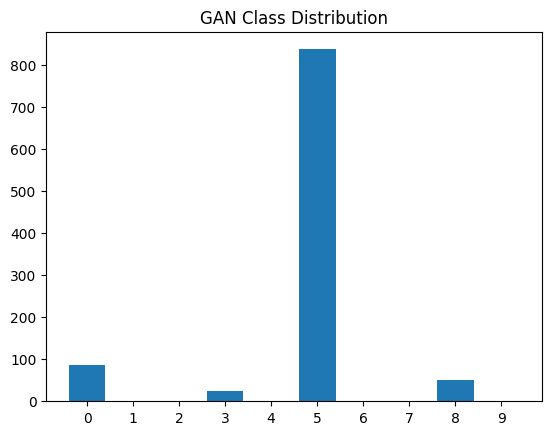

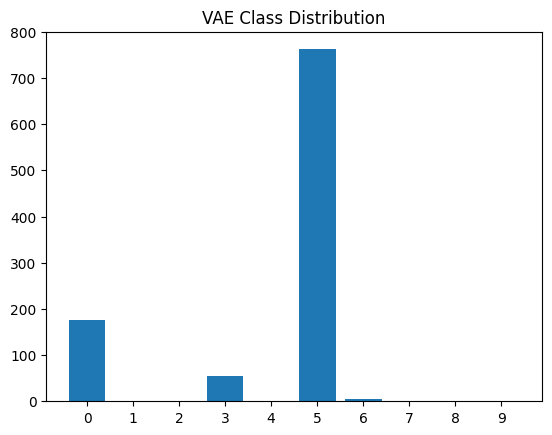

In [25]:
def plot_class_distribution(preds, title):
    counts = np.bincount(preds.cpu().numpy(), minlength=10)
    plt.bar(range(10), counts)
    plt.xticks(range(10))
    plt.title(title)
    plt.show()

plot_class_distribution(torch.tensor(gan_preds), "GAN Class Distribution")
plot_class_distribution(torch.tensor(vae_preds), "VAE Class Distribution")

Although the test we ran shows that unique classes covered by GAN were more than VAE. This could be misleading. Which is why we look at FID as well. Lower FID in GAN means feature means match determined by $\mu$. This checks out as GAN's are known for generating more sharper images. However since VAE's generate blurrier outputs, their FID score more so talks about their coverage. since our VAE's FID is somewhat close to our GAN's we know its not because of image quality but because of the diversity. The reason that VAE diversity seems lower in our experiment can be due to the classifier not being able to pick up on blurrier outputs. 

### Latent Space Interpolation

FOR VAE: $\newline$
we pick 2 test images from different classes and encode them to latent vectors $z_1$ = encoder($x_1$), $z_2$ = encoder($x_2$). We create interpolation coeffs $t \in [0,1]$ and for each $t$: $z_t = (1-t)z_1 + z_2$ then we 
decode $z_t$ through the  vae decoder to generate an image.
Stack each and save the sequence

In [26]:
def show_tensor_img(img):
    img = img.cpu().detach()
    img = (img + 1) / 2   # back to [0,1]
    img = img.permute(1, 2, 0).numpy()  # [C,H,W] -> [H,W,C]
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [27]:
from torchvision.utils import save_image
def interpolate_vae(model, img1, img2, n_steps=10, out_file="vae_interp.png"):
    model.eval()
    with torch.no_grad():
        z1, _ = model.encode(img1.unsqueeze(0).to(DEVICE))
        z2, _ = model.encode(img2.unsqueeze(0).to(DEVICE))
        alphas = np.linspace(0, 1, n_steps)
        interps = []
        for a in alphas:
            z = (1 - a) * z1 + a * z2
            x_hat = model.decode(z)
            interps.append(x_hat.cpu())
        save_image(torch.cat(interps, dim=0), out_file, nrow=n_steps, normalize=True)
    print(f"VAE interpolation saved to {out_file}")

In [28]:
def interpolate_gan(generator, z1, z2, n_steps=10, out_file="gan_interp.png"):
    generator.eval()
    with torch.no_grad():
        alphas = np.linspace(0, 1, n_steps)
        interps = []
        for a in alphas:
            z = (1 - a) * z1 + a * z2
            x_hat = generator(z)
            interps.append(x_hat.cpu())
        save_image(torch.cat(interps, dim=0), out_file, nrow=n_steps, normalize=True)
    print(f"GAN interpolation saved to {out_file}")

In [29]:
classes_list = test_data.dataset.classes
classes_list

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

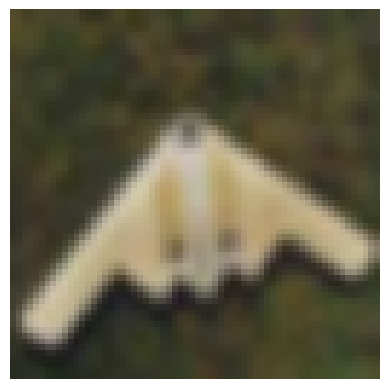

IMAGE OF airplane


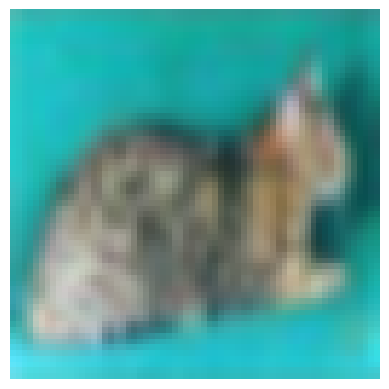

IMAGE OF cat


In [30]:
idx_a = 52
idx_b = 176
imga,labela = test_data.dataset[idx_a]
imgb,labelb = test_data.dataset[idx_b]
show_tensor_img(imga)
print(f"IMAGE OF {classes_list[labela]}")
show_tensor_img(imgb)
print(f"IMAGE OF {classes_list[labelb]}")

In [31]:
classes = test_data.dataset.classes  # CIFAR-10 class names
n_examples = 10
z_dim = 64   # change if your GAN latent dim differs

for i in range(n_examples):
    # --- Pick two images from different classes for VAE ---
    while True:
        idx_a = random.randint(0, len(test_data.dataset) - 1)
        idx_b = random.randint(0, len(test_data.dataset) - 1)
        img_a, label_a = test_data.dataset[idx_a]
        img_b, label_b = test_data.dataset[idx_b]
        if label_a != label_b:  # ensure different classes
            break

    print(f"[{i}] VAE interpolation between {classes[label_a]} and {classes[label_b]}")
    interpolate_vae(checkpoint_vae, img_a, img_b,
                    n_steps=10, out_file=f"vae_interp_{i}.png")

    # --- Random latent vectors for GAN ---
    z1 = torch.randn(1, z_dim, 1, 1, device=DEVICE)
    z2 = torch.randn(1, z_dim, 1, 1, device=DEVICE)
    print(f"[{i}] GAN interpolation (random latent)")
    interpolate_gan(checkpoint_generator, z1, z2,
                    n_steps=10, out_file=f"gan_interp_{i}.png")

[0] VAE interpolation between dog and frog
VAE interpolation saved to vae_interp_0.png
[0] GAN interpolation (random latent)
GAN interpolation saved to gan_interp_0.png
[1] VAE interpolation between frog and deer
VAE interpolation saved to vae_interp_1.png
[1] GAN interpolation (random latent)
GAN interpolation saved to gan_interp_1.png
[2] VAE interpolation between bird and deer
VAE interpolation saved to vae_interp_2.png
[2] GAN interpolation (random latent)
GAN interpolation saved to gan_interp_2.png
[3] VAE interpolation between airplane and deer
VAE interpolation saved to vae_interp_3.png
[3] GAN interpolation (random latent)
GAN interpolation saved to gan_interp_3.png
[4] VAE interpolation between airplane and dog
VAE interpolation saved to vae_interp_4.png
[4] GAN interpolation (random latent)
GAN interpolation saved to gan_interp_4.png
[5] VAE interpolation between automobile and cat
VAE interpolation saved to vae_interp_5.png
[5] GAN interpolation (random latent)
GAN interpola

### Latent Representation Analysis

In [32]:
all_z = []
all_labels = []
with torch.no_grad():
    for imgs, labels in test_data:    # test_data is a DataLoader
        imgs = imgs.to(DEVICE)
        z_mean, _ = checkpoint_vae.encode(imgs)  # use mean of q(z|x)
        all_z.append(z_mean.cpu().numpy())
        all_labels.append(labels.numpy())

all_z = np.concatenate(all_z, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

print("Latent array shape:", all_z.shape)

Latent array shape: (10000, 64)


In [33]:
class_names = test_data.dataset.classes
palette = sns.color_palette("tab10", n_colors=len(class_names))

Explained variance ratio (PCA): [0.07654687 0.04861523]


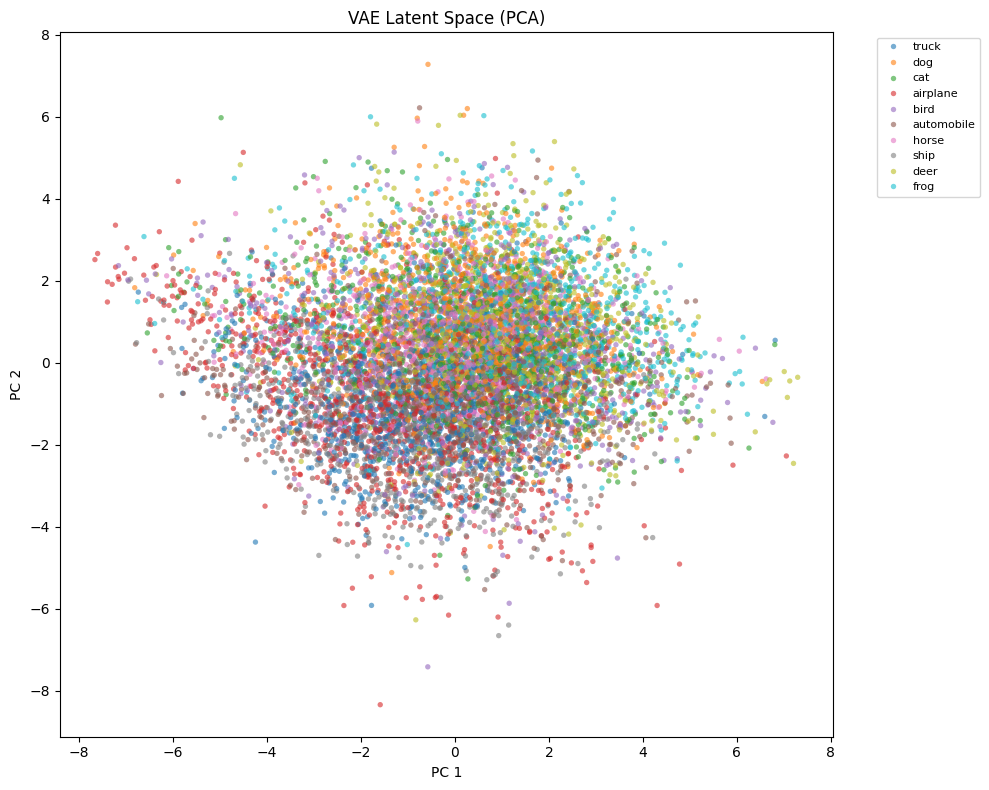

In [34]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
z_pca_2d = pca.fit_transform(all_z)
print("Explained variance ratio (PCA):", pca.explained_variance_ratio_)

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=z_pca_2d[:,0], y=z_pca_2d[:,1],
    hue=[class_names[l] for l in all_labels],
    palette=palette,
    alpha=0.6, s=15, edgecolor="none"
)
plt.title("VAE Latent Space (PCA)")
plt.xlabel("PC 1"); plt.ylabel("PC 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()


# display(pca.explained_variance_ratio_)

In [35]:
from sklearn.manifold import TSNE
pca_for_tsne = PCA(n_components=50)
z_pca = pca_for_tsne.fit_transform(all_z)

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, max_iter=2000, init='pca')
z_tsne_2d = tsne.fit_transform(z_pca)

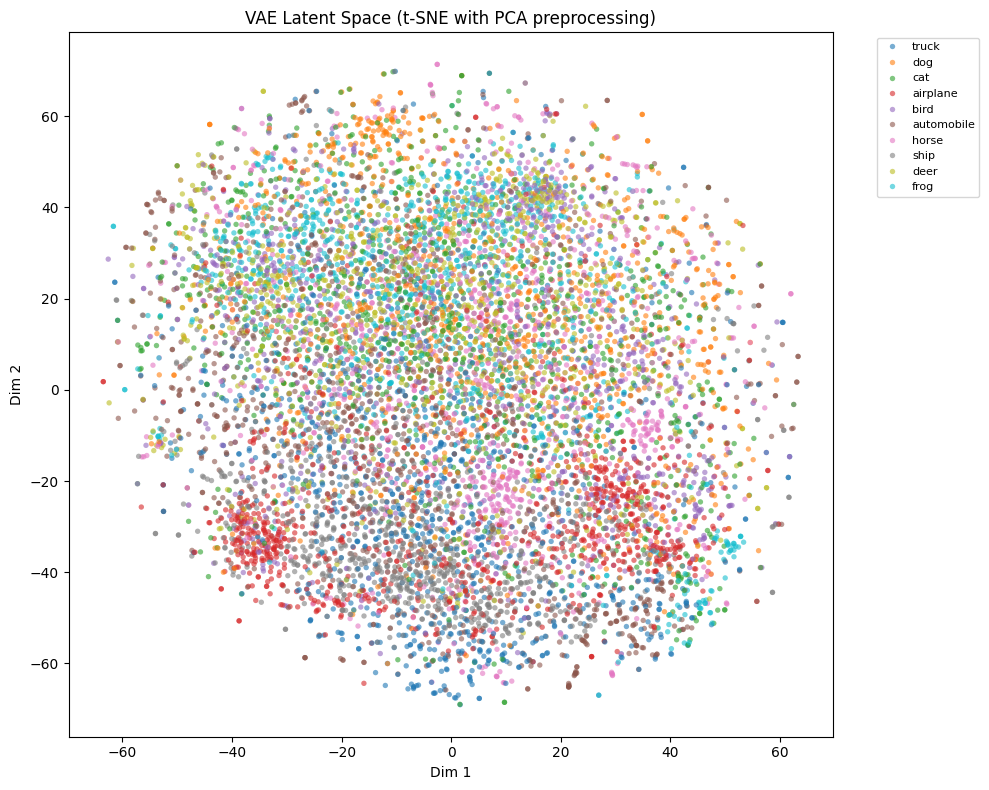

In [36]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=z_tsne_2d[:,0], y=z_tsne_2d[:,1],
    hue=[class_names[l] for l in all_labels],
    palette=palette,
    alpha=0.6, s=15, edgecolor="none"
)
plt.title("VAE Latent Space (t-SNE with PCA preprocessing)")
plt.xlabel("Dim 1"); plt.ylabel("Dim 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()

In [63]:
plt.savefig("vae_latent_tsne.png", dpi=300)

<Figure size 640x480 with 0 Axes>

### Semantic Factors

In [37]:
img, label = test_data.dataset[176]   # pick an example
img = img.to(DEVICE).unsqueeze(0)
checkpoint_vae.eval()
with torch.no_grad():
    z_mean, _ = checkpoint_vae.encode(img)      # [1, latent_dim]
z_base = z_mean.squeeze(0).cpu()     # [latent_dim]
print("Latent dim:", z_base.shape[0])

Latent dim: 64


In [38]:
def latent_traversal(model, z_base, dim_idx, sweep=(-3,3), steps=7, out_file=None):
    z_base = z_base.clone()
    alphas = np.linspace(sweep[0], sweep[1], steps)
    imgs = []
    model.eval()
    with torch.no_grad():
        for a in alphas:
            z_new = z_base.clone()
            z_new[dim_idx] = a
            x_hat = model.decode(z_new.unsqueeze(0).to(DEVICE))
            imgs.append(x_hat.cpu())
    grid = torch.cat(imgs, dim=0)
    if out_file:
        save_image(grid, out_file, nrow=steps, normalize=True)
    return grid


In [39]:
for dim in range(10):
    fname = f"latent_traversal_dim{dim}.png"
    latent_traversal(checkpoint_vae, z_base, dim_idx=dim, steps=9, out_file=fname)
    print(f"Saved traversal for dimension {dim} -> {fname}")

Saved traversal for dimension 0 -> latent_traversal_dim0.png
Saved traversal for dimension 1 -> latent_traversal_dim1.png
Saved traversal for dimension 2 -> latent_traversal_dim2.png
Saved traversal for dimension 3 -> latent_traversal_dim3.png
Saved traversal for dimension 4 -> latent_traversal_dim4.png
Saved traversal for dimension 5 -> latent_traversal_dim5.png
Saved traversal for dimension 6 -> latent_traversal_dim6.png
Saved traversal for dimension 7 -> latent_traversal_dim7.png
Saved traversal for dimension 8 -> latent_traversal_dim8.png
Saved traversal for dimension 9 -> latent_traversal_dim9.png


do this interpreation beth ke

FOR GAN

In [40]:
n_samples = 5000
fixed_noise = torch.randn(n_samples, z_dim).to(DEVICE)

In [41]:
with torch.no_grad():
    # Example: use generator input space
    feats = fixed_noise.detach().cpu().numpy()

pca = PCA(n_components=10)  # compute first 10 PCs
pca.fit(feats)
print("Explained variance ratios:", pca.explained_variance_ratio_)

Explained variance ratios: [0.01907846 0.01891363 0.01872466 0.0184838  0.01826901 0.01814768
 0.01803362 0.01799187 0.01786579 0.0178377 ]


In [42]:
pc_index = 0                 # choose which PC to explore
pc_direction = torch.from_numpy(pca.components_[pc_index]).float().to(DEVICE)

seed = torch.randn(1, z_dim).to(DEVICE)  # starting latent code
steps = 11                               # number of interpolation steps
alphas = torch.linspace(-3, 3, steps)

In [43]:
images = []
os.makedirs("gan_pca_results",exist_ok=True)
with torch.no_grad():
    for a in alphas:
        z_new = (seed + a * pc_direction).unsqueeze(2).unsqueeze(3)
        img = checkpoint_generator(z_new).cpu()
        images.append(img)

# Save horizontal grid
save_image(torch.cat(images, dim=0), "gan_pca_results/pca_traversal_pc0.png",
           nrow=steps, normalize=True, value_range=(-1, 1))
print("Saved PCA traversal to gan_pca_results/pca_traversal_pc0.png")

Saved PCA traversal to gan_pca_results/pca_traversal_pc0.png


### OOD input

#### VAE OOD

In [74]:
transformer_fmnist = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64, 64)),  # or 32x32 if CIFAR-10
    torchvision.transforms.Grayscale(num_output_channels=3),  # converts 1->3 channels
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

In [75]:
fmnist_dataset = torchvision.datasets.FashionMNIST(root="./datasets", train=False, download=True, transform=transformer_fmnist)
ood_loader = torch.utils.data.DataLoader(fmnist_dataset, batch_size=16, shuffle=True)

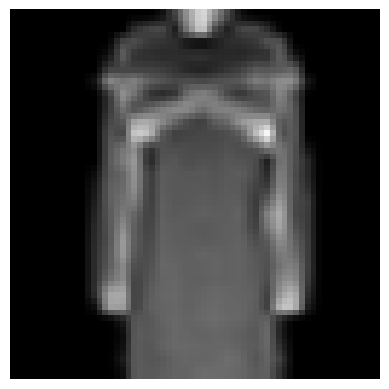

In [88]:
ood_imgs, ood_labels = next(iter(ood_loader))
show_tensor_img(ood_imgs[0])
# ood_imgs.to(DEVICE)

In [89]:
with torch.inference_mode():
    ood_imgs = ood_imgs.to(DEVICE)
    x_hat, _, _ = checkpoint_vae(ood_imgs)

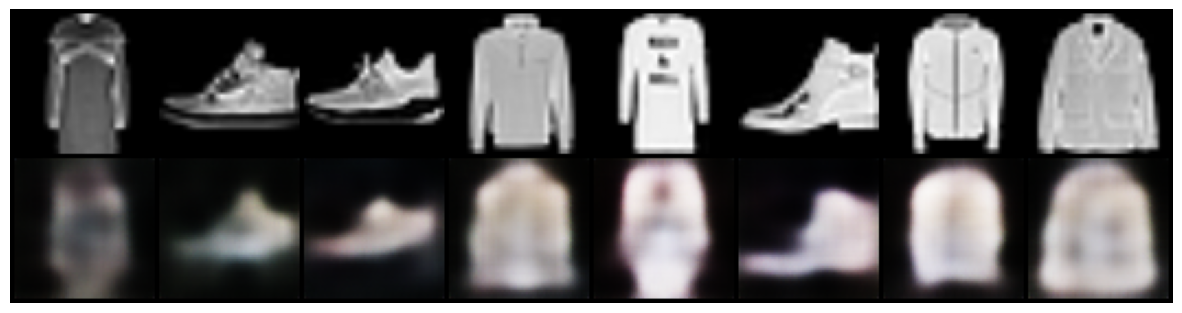

In [90]:
def show_reconstruction(original, recon, n=8):
    # Arrange side-by-side (first row: input, second: reconstruction)
    grid = torch.cat([original[:n], recon[:n]], dim=0)
    grid = make_grid(grid, nrow=n, normalize=True, value_range=(-1,1))
    plt.figure(figsize=(15,4))
    plt.imshow(grid.permute(1,2,0).cpu())
    plt.axis('off')
    plt.show()

show_reconstruction(ood_imgs, x_hat)

In [91]:
def reconstruction_error(model, data_loader, device):
    model.eval()
    errors = []
    with torch.no_grad():
        for x, _ in data_loader:          # x is a batch of images
            x = x.to(device)
            x_hat, _, _ = model(x)
            # MSE per image
            batch_err = F.mse_loss(x_hat, x, reduction='none')
            # Reduce over channels, height, width to a single value per image
            batch_err = batch_err.view(batch_err.size(0), -1).mean(dim=1)
            errors.append(batch_err.cpu())
    return torch.cat(errors)

# Example usage:
id_errors  = reconstruction_error(checkpoint_vae, test_data, DEVICE)
ood_errors = reconstruction_error(checkpoint_vae, ood_loader, DEVICE)

In [92]:
print(f"ID mean error : {id_errors.mean():.4f}")
print(f"OOD mean error: {ood_errors.mean():.4f}")

ID mean error : 0.0319
OOD mean error: 0.0513


#### GAN OOD

In [93]:
def show_images(imgs, title=None):
    imgs = (imgs + 1) / 2  # if normalized to [-1,1]
    imgs = imgs.detach().cpu()
    grid = torchvision.utils.make_grid(imgs, nrow=16)
    plt.figure(figsize=(8,8))
    plt.imshow(grid.permute(1,2,0))
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

In [94]:
z_id = torch.randn(128,z_dim,1,1,device=DEVICE)
z_ood = torch.randn(128, z_dim, 1,1, device=DEVICE)*5.0
img_ood = checkpoint_generator(z_ood)
img_id = checkpoint_generator(z_id)
img_id.shape, img_ood.shape


(torch.Size([128, 3, 64, 64]), torch.Size([128, 3, 64, 64]))

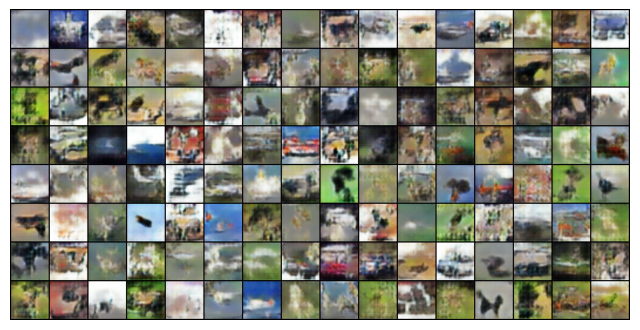

In [95]:
show_images(img_id)

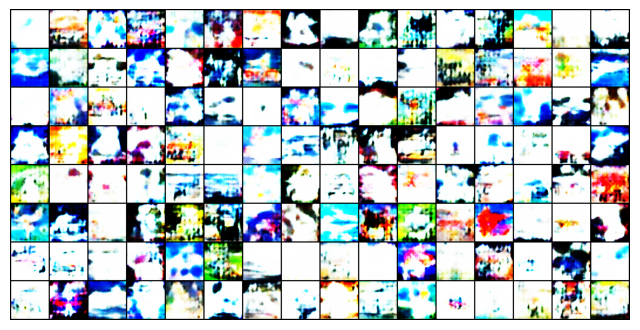

In [96]:
show_images(img_ood)

### Anomaly Detection

In [97]:
def compute_recon_mse(loader):
    mse_list = []
    for x, _ in loader:
        x = x.to(DEVICE)
        with torch.no_grad():
            x_hat, _, _ = checkpoint_vae(x)
        mse = ((x - x_hat) ** 2).mean(dim=[1,2,3])  # MSE per image
        mse_list.append(mse.cpu())
    return torch.cat(mse_list)

In [98]:
mse_cifar = compute_recon_mse(test_data)
mse_ood = compute_recon_mse(ood_loader)

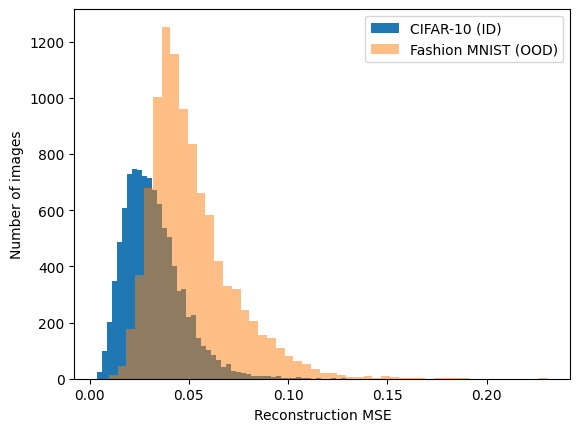

In [100]:
plt.hist(mse_cifar.numpy(), bins=50, alpha=1, label="CIFAR-10 (ID)")
plt.hist(mse_ood.numpy(), bins=50, alpha=0.5, label="Fashion MNIST (OOD)")
plt.xlabel("Reconstruction MSE")
plt.ylabel("Number of images")
plt.legend()
plt.show()

In [101]:
threshold = mse_cifar.mean() + 2 * mse_cifar.std()
print(f"Threshold for OOD detection: {threshold.item()}")
print(f"CIFAR-10 above threshold: {(mse_cifar > threshold).float().mean().item()*100:.2f}%")
print(f"OOD above threshold: {(mse_ood > threshold).float().mean().item()*100:.2f}%")

Threshold for OOD detection: 0.06117040663957596
CIFAR-10 above threshold: 4.07%
OOD above threshold: 24.72%
